# Note:
The geographic locations of participating households, used to conduct spatial analyses, cannot be publicly available due to data privacy and ethical considerations. Regarding the built environment data, the latter is under copyrights, and hence, cannot be publicly distributed.

In [1]:
import os
from pathlib import Path
from os import path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Polygon

# 1. Input data

In [2]:
cwd = os.getcwd()
root_dir = Path(cwd).parent

In [3]:
## Survey data

# Individual data
data_IND_tot = pd.read_csv(path.join(root_dir,
                                    "data/raw/individual_data.csv"))

# Household data
data_HH_tot = pd.read_csv(path.join(root_dir,
                                    "data/raw/household_data.csv"))

# Survey areas
sar_AZ = gpd.read_file(path.join(root_dir,
                                 "data/raw/maps/Azi_perimetre_ZONES_EurSpImg.shp"))
sar_WI = gpd.read_file(path.join(root_dir,
                                 "data/raw/maps/Willy_perimetre_ZONES_EurSpImg.shp"))

## Geodata (data under copyrights, not publicly available)

# Built environment
bdg_azi = gpd.read_file(path.join(root_dir,
                                  "data_confidential/raw/maps/ABI_azito/buildingsVPC_manual_220127.shp"))
bdg_azi = bdg_azi.to_crs(32630)
bdg_azi_ctxt = gpd.read_file(path.join(root_dir,
                                       "data_confidential/raw/maps/ABI_azito/Azito_buildings_momepy.shp"))
bdg_azi_ctxt = bdg_azi_ctxt.to_crs(32630)
bdg_willy = gpd.read_file(path.join(root_dir,
                                    "data_confidential/raw/maps/ABI_williamsville/buildingsVPC_manual_220216_willy.shp"))
bdg_willy = bdg_willy.to_crs(32630)
bdg_willy_ctxt = gpd.read_file(path.join(root_dir,
                                         "data_confidential/raw/maps/ABI_williamsville/Willy_buildings_momepy.shp"))
bdg_willy_ctxt = bdg_willy_ctxt.to_crs(32630)

# Water surfaces
wat_azi_ctxt = gpd.read_file(path.join(root_dir,
                                       "data_confidential/raw/maps/ABI_azito/Lagune.gpkg"))
wat_azi_ctxt = wat_azi_ctxt.to_crs(32630)
wat_willy_ctxt = gpd.read_file(path.join(root_dir,
                                         "data_confidential/raw/maps/ABI_williamsville/230314_CANIVEAUX_buffered.gpkg"))
wat_willy_ctxt = wat_willy_ctxt.to_crs(32630)

# 2. Preprocess data: aggregate attributes by survey area

## 2.1. Prevalence of diarrhoea

In [4]:
## General population: count cases and target population by survey area

# dummy dataframe
df = data_IND_tot.copy()

# variable to count cases
df['Dcnt'] = np.nan
df['Dcnt'][df['Diarrhoea']=='N'] = 0
df['Dcnt'][df['Diarrhoea']=='Y'] = 1
valid_data_mask = (~df["Dcnt"].isna())

# aggregate by area
df_diarr_genpop = df[valid_data_mask].groupby(df['SurveyArea']).Dcnt.agg(['sum','count']).reset_index()
df_diarr_genpop['prev_gen'] = (df_diarr_genpop['sum']/df_diarr_genpop['count'])*100
df_diarr_genpop = df_diarr_genpop.rename(columns={"sum": "cases_gen","count": "cnt_gen"})


## Children under 5: count cases and target population by survey area

# dummy dataframe
df = data_IND_tot[data_IND_tot.Age<5].copy()

# variable to count cases
df['Dcnt'] = np.nan
df['Dcnt'][df['Diarrhoea']=='N'] = 0
df['Dcnt'][df['Diarrhoea']=='Y'] = 1
valid_data_mask = (~df["Dcnt"].isna())

# aggregate by area
df_diarr_u5 = df[valid_data_mask].groupby(df['SurveyArea']).Dcnt.agg(['sum','count']).reset_index()
df_diarr_u5['prev_u5'] = (df_diarr_u5['sum']/df_diarr_u5['count'])*100
df_diarr_u5 = df_diarr_u5.rename(columns={"sum": "cases_u5","count": "cnt_u5"})


## Generate single table
df_aggr_sar = df_diarr_genpop.merge(df_diarr_u5,how='left',on='SurveyArea')

# check results
df_aggr_sar

SurveyArea  cases_gen  cnt_gen   prev_gen  cases_u5  cnt_u5    prev_u5
0        AZ1       10.0       82  12.195122       2.0      11  18.181818
1        AZ2       58.0      305  19.016393       9.0      31  29.032258
2        AZ3       28.0      238  11.764706       4.0      21  19.047619
3        AZ4       17.0      316   5.379747       4.0      33  12.121212
4        AZ5       61.0      224  27.232143      15.0      28  53.571429
5         W1       29.0      266  10.902256       6.0      31  19.354839
6         W2       21.0      233   9.012876       4.0      27  14.814815
7         W3       25.0      298   8.389262       4.0      37  10.810811
8         W4       20.0      246   8.130081       4.0      29  13.793103
9         W5       84.0      230  36.521739      17.0      33  51.515152

## 2.2. Access to basic WASH services

In [5]:
## Percentage of households with water piped to premises by survey area

# dummy dataframe
df = data_HH_tot.copy()

# variable to count (i): basic water
basic_wt_mask = (((df["DrinkingWaterGroup"]=='Private')&
                  (df["DrinkingWater_Private"].isin(['Piped_dwel','Piped_yard'])))|
                 ((df["DrinkingWaterGroup"]=='Private')&
                  (df["DrinkingWater_Private"].isin(['Piped_neigh']))&
                  (df["DrinkingWaterDist"]<=30))|
                 ((df["DrinkingWaterGroup"]=='Public')&
                  (df["DrinkingWater_Public"].isin(['Vendor','Ground_tube']))&
                  (df["DrinkingWaterDist"]<=30)))
df["BasicWtCnt"] = np.nan
df["BasicWtCnt"][(~df["DrinkingWaterGroup"].isna())] = 0
df["BasicWtCnt"][basic_wt_mask] = 1

# variable to count (ii): basic sanitation
basic_sn_mask = ((((df.ToiletFacilityTYPE=='DryOrCompost')&
                   (df.ToiletFacilityTYPE_Dry.isin(['Dry_ImprSlab',
                                                    'Dry_VIP'])))|
                  ((df.ToiletFacilityTYPE=='Flush')&
                   (df.ToiletFacilityTYPE_Flush.isin(['Flush_piped',
                                                      'Flush_septic_tank',
                                                      'Flush_coveredPit']))))&
                 (df.ToiletROOF=='Y')&
                 (df.ToiletFacilitySHARE=='N'))
df["BasicSanCnt"] = np.nan
df["BasicSanCnt"][(~df["ToiletFacility"].isna())] = 0
df["BasicSanCnt"][basic_sn_mask] = 1

# variable to count (iii): basic hygiene
hg_avail_mask = ((df["ObsHandWashWATER"]=='Water_OK')& # water available at the moment of the survey
                 (df["ObsHandWashSOAP"]=='SoapOrDeterg')& # soap available at the moment of the survey
                 (df["ObsHandWashPLACE"]=='Obs_Fixed')) # presence of fixed hand-washing structure
df["BasicHygCnt"] = np.nan
df["BasicHygCnt"][(~df["ObsHandWashWATER"].isna())&
                  (~df["ObsHandWashSOAP"].isna())&
                  (~df["ObsHandWashPLACE"].isna())] = 0
df["BasicHygCnt"][hg_avail_mask] = 1

# variable to count (final): basic WASH
basic_wash_mask = ((df["BasicWtCnt"]==1)& # access to basic water
                   (df["BasicSanCnt"]==1)& # access to basic sanitation
                   (df["BasicHygCnt"]==1)) # access to basic hygiene
valid_data_mask = ((~df["DrinkingWaterGroup"].isna())&
                   (~df["ToiletFacility"].isna())&
                   (~df["ObsHandWashWATER"].isna())&
                   (~df["ObsHandWashSOAP"].isna())&
                   (~df["ObsHandWashPLACE"].isna()))
df["BasicWASHcnt"] = np.nan
df["BasicWASHcnt"][valid_data_mask] = 0
df["BasicWASHcnt"][basic_wash_mask] = 1

# aggregate by area
df_basic_wash = df[valid_data_mask].groupby(df['SurveyArea']).BasicWASHcnt.agg(['sum','count']).reset_index()
df_basic_wash['pc_wash'] = (df_basic_wash['sum']/df_basic_wash['count'])*100
df_basic_hyg = df[valid_data_mask].groupby(df['SurveyArea']).BasicHygCnt.agg(['sum','count']).reset_index()
df_basic_hyg['pc_bhyg'] = (df_basic_hyg['sum']/df_basic_hyg['count'])*100

## Generate single table
df_aggr_sar = df_aggr_sar.merge(df_basic_wash[['SurveyArea','pc_wash']],how='left',on='SurveyArea')
df_aggr_sar = df_aggr_sar.merge(df_basic_hyg[['SurveyArea','pc_bhyg']],how='left',on='SurveyArea')

# check results
df_aggr_sar

SurveyArea  cases_gen  cnt_gen   prev_gen  cases_u5  cnt_u5    prev_u5  \
0        AZ1       10.0       82  12.195122       2.0      11  18.181818   
1        AZ2       58.0      305  19.016393       9.0      31  29.032258   
2        AZ3       28.0      238  11.764706       4.0      21  19.047619   
3        AZ4       17.0      316   5.379747       4.0      33  12.121212   
4        AZ5       61.0      224  27.232143      15.0      28  53.571429   
5         W1       29.0      266  10.902256       6.0      31  19.354839   
6         W2       21.0      233   9.012876       4.0      27  14.814815   
7         W3       25.0      298   8.389262       4.0      37  10.810811   
8         W4       20.0      246   8.130081       4.0      29  13.793103   
9         W5       84.0      230  36.521739      17.0      33  51.515152   

     pc_wash    pc_bhyg  
0  72.000000  76.000000  
1  53.030303  59.090909  
2  42.553191  44.680851  
3  30.909091  38.181818  
4  13.207547  20.754717  
5  25.000000  30.357143  
6   3.448276   5.172414  
7   3.030303   9.090909  
8   0.000000   3.773585  
9   3.076923  12.307692

## 2.3. Precarious construction materials

In [6]:
## Percentage of dwellings built with precarious construction materials by survey area

# dummy dataframe
df = data_HH_tot.copy()

# variable to count cases
prec_h_mask = ((df["HHEXTWALLS"].isin(['Stone_mud','ReusedWoodOrBamboo','Metal']))|
               (df["HHFLOOR"].isin(['Other']))|
               (df["HHROOF"].isin(['Rustic_metal','Rustic_toles_fibr','Rustic_planks','Rustic_plastic'])))
df["PrHMcnt"] = np.nan
df["PrHMcnt"][(~df["HHEXTWALLS"].isna())&(~df["HHFLOOR"].isna())&(~df["HHROOF"].isna())] = 0
df["PrHMcnt"][prec_h_mask] = 1
valid_data_mask = (~df["PrHMcnt"].isna())

# aggregate by area
df_prchhmt = df[valid_data_mask].groupby(df['SurveyArea']).PrHMcnt.agg(['sum','count']).reset_index()
df_prchhmt['pc_precmat'] = (df_prchhmt['sum']/df_prchhmt['count'])*100


## Generate single table
df_aggr_sar = df_aggr_sar.merge(df_prchhmt[['SurveyArea','pc_precmat']],how='left',on='SurveyArea')

# check results
df_aggr_sar

SurveyArea  cases_gen  cnt_gen   prev_gen  cases_u5  cnt_u5    prev_u5  \
0        AZ1       10.0       82  12.195122       2.0      11  18.181818   
1        AZ2       58.0      305  19.016393       9.0      31  29.032258   
2        AZ3       28.0      238  11.764706       4.0      21  19.047619   
3        AZ4       17.0      316   5.379747       4.0      33  12.121212   
4        AZ5       61.0      224  27.232143      15.0      28  53.571429   
5         W1       29.0      266  10.902256       6.0      31  19.354839   
6         W2       21.0      233   9.012876       4.0      27  14.814815   
7         W3       25.0      298   8.389262       4.0      37  10.810811   
8         W4       20.0      246   8.130081       4.0      29  13.793103   
9         W5       84.0      230  36.521739      17.0      33  51.515152   

     pc_wash    pc_bhyg  pc_precmat  
0  72.000000  76.000000   38.461538  
1  53.030303  59.090909    9.722222  
2  42.553191  44.680851   30.612245  
3  30.909091  38.181818    5.263158  
4  13.207547  20.754717   12.903226  
5  25.000000  30.357143    0.000000  
6   3.448276   5.172414   20.689655  
7   3.030303   9.090909   55.223881  
8   0.000000   3.773585    0.000000  
9   3.076923  12.307692   44.615385

## 2.4. Indoors cooking space

In [7]:
## Percentage of households with an indoors cooking space by survey area

# dummy dataframe
df = data_HH_tot.copy()

# variable to count cases
cook_mask = (df["HHCOOKING"]=='House')# cooking done inside dwelling
df["CookCnt"] = np.nan
df["CookCnt"][~df["HHCOOKING"].isna()] = 0
df["CookCnt"][cook_mask] = 1
valid_data_mask = (~df["CookCnt"].isna())

# aggregate by area
df_cookind = df[valid_data_mask].groupby(df['SurveyArea']).CookCnt.agg(['sum','count']).reset_index()
df_cookind['pc_cookind'] = (df_cookind['sum']/df_cookind['count'])*100


## Generate single table
df_aggr_sar = df_aggr_sar.merge(df_cookind[['SurveyArea','pc_cookind']],how='left',on='SurveyArea')


## Percentage of households cooking outdoors (relevant for Azito, opposite trend than in Williamsville)
df_aggr_sar['pc_cookout'] = 100-df_aggr_sar['pc_cookind']

## check results
df_aggr_sar

SurveyArea  cases_gen  cnt_gen   prev_gen  cases_u5  cnt_u5    prev_u5  \
0        AZ1       10.0       82  12.195122       2.0      11  18.181818   
1        AZ2       58.0      305  19.016393       9.0      31  29.032258   
2        AZ3       28.0      238  11.764706       4.0      21  19.047619   
3        AZ4       17.0      316   5.379747       4.0      33  12.121212   
4        AZ5       61.0      224  27.232143      15.0      28  53.571429   
5         W1       29.0      266  10.902256       6.0      31  19.354839   
6         W2       21.0      233   9.012876       4.0      27  14.814815   
7         W3       25.0      298   8.389262       4.0      37  10.810811   
8         W4       20.0      246   8.130081       4.0      29  13.793103   
9         W5       84.0      230  36.521739      17.0      33  51.515152   

     pc_wash    pc_bhyg  pc_precmat  pc_cookind  pc_cookout  
0  72.000000  76.000000   38.461538  100.000000    0.000000  
1  53.030303  59.090909    9.722222   73.611111   26.388889  
2  42.553191  44.680851   30.612245   71.428571   28.571429  
3  30.909091  38.181818    5.263158   82.456140   17.543860  
4  13.207547  20.754717   12.903226   54.838710   45.161290  
5  25.000000  30.357143    0.000000   60.344828   39.655172  
6   3.448276   5.172414   20.689655   27.586207   72.413793  
7   3.030303   9.090909   55.223881   46.268657   53.731343  
8   0.000000   3.773585    0.000000   62.264151   37.735849  
9   3.076923  12.307692   44.615385   16.923077   83.076923

## 2.5. Availability of water during the month preceding the survey

In [8]:
## Percentage of households having lacked water in the month preceding the survey, by survey area

# dummy dataframe
df = data_HH_tot.copy()

# variable to count cases
wt_avail_mask = (df["DrinkingWaterAvailability"]=='Y') # lack of water in the previous month
df["AvlbWtMcnt"] = np.nan
df["AvlbWtMcnt"][~df["DrinkingWaterAvailability"].isna()] = 0
df["AvlbWtMcnt"][wt_avail_mask] = 1
valid_data_mask = (~df["AvlbWtMcnt"].isna())

# aggregate by area
df_wtav = df[valid_data_mask].groupby(df['SurveyArea']).AvlbWtMcnt.agg(['sum','count']).reset_index()
df_wtav['pc_wt_avm'] = (df_wtav['sum']/df_wtav['count'])*100


## Generate single table
df_aggr_sar = df_aggr_sar.merge(df_wtav[['SurveyArea','pc_wt_avm']],how='left',on='SurveyArea')

# check results
df_aggr_sar

SurveyArea  cases_gen  cnt_gen   prev_gen  cases_u5  cnt_u5    prev_u5  \
0        AZ1       10.0       82  12.195122       2.0      11  18.181818   
1        AZ2       58.0      305  19.016393       9.0      31  29.032258   
2        AZ3       28.0      238  11.764706       4.0      21  19.047619   
3        AZ4       17.0      316   5.379747       4.0      33  12.121212   
4        AZ5       61.0      224  27.232143      15.0      28  53.571429   
5         W1       29.0      266  10.902256       6.0      31  19.354839   
6         W2       21.0      233   9.012876       4.0      27  14.814815   
7         W3       25.0      298   8.389262       4.0      37  10.810811   
8         W4       20.0      246   8.130081       4.0      29  13.793103   
9         W5       84.0      230  36.521739      17.0      33  51.515152   

     pc_wash    pc_bhyg  pc_precmat  pc_cookind  pc_cookout  pc_wt_avm  
0  72.000000  76.000000   38.461538  100.000000    0.000000  26.923077  
1  53.030303  59.090909    9.722222   73.611111   26.388889  27.777778  
2  42.553191  44.680851   30.612245   71.428571   28.571429  22.448980  
3  30.909091  38.181818    5.263158   82.456140   17.543860  73.684211  
4  13.207547  20.754717   12.903226   54.838710   45.161290  70.491803  
5  25.000000  30.357143    0.000000   60.344828   39.655172  27.586207  
6   3.448276   5.172414   20.689655   27.586207   72.413793   8.620690  
7   3.030303   9.090909   55.223881   46.268657   53.731343  19.402985  
8   0.000000   3.773585    0.000000   62.264151   37.735849  11.320755  
9   3.076923  12.307692   44.615385   16.923077   83.076923  41.538462

## 2.6. Socioeconomic status ('high' & 'mid-low' strata)

In [9]:
## Percentage of households in the 'high' socioeconomic stratum 

# dummy dataframe
df = data_HH_tot.copy()

# variable to count (i): asset-based wealth
df["ItemsScore"]=(df["HHITEMS/Computer"]+df["HHITEMS/Electricity"]+
                  df["HHITEMS/Internet"]+df["HHITEMS/Oven"]+
                  df["HHITEMS/Radio"]+df["HHITEMS/Refrigerator"]+
                  df["HHITEMS/Smartphone"]+df["HHITEMS/Television"])
df["ItemsScore"][(df["HHITEMS/Noitems"]==1)] = 0
df["ItemsScore"][(df["HHITEMS/NA"]==1)] = np.nan
wt_wealth_mask = (df["ItemsScore"]>df["ItemsScore"].mean())# Number of items above the mean (of all the surveyed households)
df["WealHHcnt"] = np.nan
df["WealHHcnt"][~df["ItemsScore"].isna()] = 0
df["WealHHcnt"][wt_wealth_mask] = 1

# variable to count (ii): education level of head of household
src = data_IND_tot[data_IND_tot.Relation_to_HH=='Head'][['PARENT_KEY',
                                                         'School_past']]# subset ed. level of HH
src = src.rename(columns={"PARENT_KEY": "KEY"})# rename key variable allowing for data join
# Recode education level of heads of households
src['SecEdCnt'] = np.nan
src['SecEdCnt'][src['School_past'].isin(['No_Edu',
                                         'Early_CdE',
                                         'Primary',
                                         'Coranic'])] = 0 # up to primary education
src['SecEdCnt'][src['School_past'].isin(['Secondary',
                                         'Secondary_1',
                                         'Secondary_2',
                                         'High_Ed'])] = 1 # secondary or higher education
src = src[~src.SecEdCnt.isna()]
# In case a same household has 2 heads, merge lines
src = src[['SecEdCnt','KEY']].groupby(by="KEY").max().reset_index()
# Attribute education level of heads of households
df = df.merge(src,on="KEY",how='left')

# variable to count (final): socioeconomic stratum
hi_soceco_mask = ((df["WealHHcnt"]==1)&
                  (df["SecEdCnt"]==1))
df["HiSocEcoCnt"] = np.nan
df["HiSocEcoCnt"][(~df["WealHHcnt"].isna())&(~df["SecEdCnt"].isna())] = 0
df["HiSocEcoCnt"][hi_soceco_mask] = 1
valid_data_mask = (~df["HiSocEcoCnt"].isna())

# aggregate by area
df_soceco = df[valid_data_mask].groupby(df['SurveyArea']).HiSocEcoCnt.agg(['sum','count']).reset_index()
df_soceco['pc_hi_soceco'] = (df_soceco['sum']/df_soceco['count'])*100


## Generate single table
df_aggr_sar = df_aggr_sar.merge(df_soceco[['SurveyArea','pc_hi_soceco']],how='left',on='SurveyArea')

# check results
df_aggr_sar

SurveyArea  cases_gen  cnt_gen   prev_gen  cases_u5  cnt_u5    prev_u5  \
0        AZ1       10.0       82  12.195122       2.0      11  18.181818   
1        AZ2       58.0      305  19.016393       9.0      31  29.032258   
2        AZ3       28.0      238  11.764706       4.0      21  19.047619   
3        AZ4       17.0      316   5.379747       4.0      33  12.121212   
4        AZ5       61.0      224  27.232143      15.0      28  53.571429   
5         W1       29.0      266  10.902256       6.0      31  19.354839   
6         W2       21.0      233   9.012876       4.0      27  14.814815   
7         W3       25.0      298   8.389262       4.0      37  10.810811   
8         W4       20.0      246   8.130081       4.0      29  13.793103   
9         W5       84.0      230  36.521739      17.0      33  51.515152   

     pc_wash    pc_bhyg  pc_precmat  pc_cookind  pc_cookout  pc_wt_avm  \
0  72.000000  76.000000   38.461538  100.000000    0.000000  26.923077   
1  53.030303  59.090909    9.722222   73.611111   26.388889  27.777778   
2  42.553191  44.680851   30.612245   71.428571   28.571429  22.448980   
3  30.909091  38.181818    5.263158   82.456140   17.543860  73.684211   
4  13.207547  20.754717   12.903226   54.838710   45.161290  70.491803   
5  25.000000  30.357143    0.000000   60.344828   39.655172  27.586207   
6   3.448276   5.172414   20.689655   27.586207   72.413793   8.620690   
7   3.030303   9.090909   55.223881   46.268657   53.731343  19.402985   
8   0.000000   3.773585    0.000000   62.264151   37.735849  11.320755   
9   3.076923  12.307692   44.615385   16.923077   83.076923  41.538462   

   pc_hi_soceco  
0     72.727273  
1     70.491803  
2     43.181818  
3     50.980392  
4     41.379310  
5     23.913043  
6      8.771930  
7     12.903226  
8     12.500000  
9      5.084746

## 2.7. Join attributes (from tables to geometries)

In [10]:
## Azito

# Rename key variable of geodataframe
sar_AZ = sar_AZ.rename(columns={"nom_zone": "SurveyArea"})

# Join attributes by area identifier
sar_AZ = sar_AZ.merge(df_aggr_sar,how='left',on='SurveyArea')

# Check results
sar_AZ

SurveyArea                                           geometry  cases_gen  \
0        AZ1  POLYGON ((380103.474 586588.904, 380164.224 58...       10.0   
1        AZ2  POLYGON ((379877.842 586353.234, 379953.205 58...       58.0   
2        AZ4  POLYGON ((380116.416 586166.140, 380100.253 58...       17.0   
3        AZ3  POLYGON ((380169.979 586379.381, 380241.371 58...       28.0   
4        AZ5  POLYGON ((380116.416 586166.140, 380182.947 58...       61.0   

   cnt_gen   prev_gen  cases_u5  cnt_u5    prev_u5    pc_wash    pc_bhyg  \
0       82  12.195122       2.0      11  18.181818  72.000000  76.000000   
1      305  19.016393       9.0      31  29.032258  53.030303  59.090909   
2      316   5.379747       4.0      33  12.121212  30.909091  38.181818   
3      238  11.764706       4.0      21  19.047619  42.553191  44.680851   
4      224  27.232143      15.0      28  53.571429  13.207547  20.754717   

   pc_precmat  pc_cookind  pc_cookout  pc_wt_avm  pc_hi_soceco  
0   38.461538  100.000000    0.000000  26.923077     72.727273  
1    9.722222   73.611111   26.388889  27.777778     70.491803  
2    5.263158   82.456140   17.543860  73.684211     50.980392  
3   30.612245   71.428571   28.571429  22.448980     43.181818  
4   12.903226   54.838710   45.161290  70.491803     41.379310

In [11]:
## Williamsville

# Rename key variable of geodataframe
sar_WI = sar_WI.rename(columns={"nom_zone": "SurveyArea"})

# Join attributes by area identifier
sar_WI = sar_WI.merge(df_aggr_sar,how='left',on='SurveyArea')

# Check results
sar_WI

SurveyArea                                           geometry  cases_gen  \
0         W1  POLYGON ((386377.924 594008.549, 386395.313 59...       29.0   
1         W3  POLYGON ((386467.924 593861.572, 386485.283 59...       25.0   
2         W2  POLYGON ((386579.972 593772.034, 386573.606 59...       21.0   
3         W4  POLYGON ((386594.511 593811.943, 386599.349 59...       20.0   
4         W5  POLYGON ((386579.972 593772.034, 386583.550 59...       84.0   

   cnt_gen   prev_gen  cases_u5  cnt_u5    prev_u5    pc_wash    pc_bhyg  \
0      266  10.902256       6.0      31  19.354839  25.000000  30.357143   
1      298   8.389262       4.0      37  10.810811   3.030303   9.090909   
2      233   9.012876       4.0      27  14.814815   3.448276   5.172414   
3      246   8.130081       4.0      29  13.793103   0.000000   3.773585   
4      230  36.521739      17.0      33  51.515152   3.076923  12.307692   

   pc_precmat  pc_cookind  pc_cookout  pc_wt_avm  pc_hi_soceco  
0    0.000000   60.344828   39.655172  27.586207     23.913043  
1   55.223881   46.268657   53.731343  19.402985     12.903226  
2   20.689655   27.586207   72.413793   8.620690      8.771930  
3    0.000000   62.264151   37.735849  11.320755     12.500000  
4   44.615385   16.923077   83.076923  41.538462      5.084746

# 3. Plot maps

## 3.1. Diarrhoea

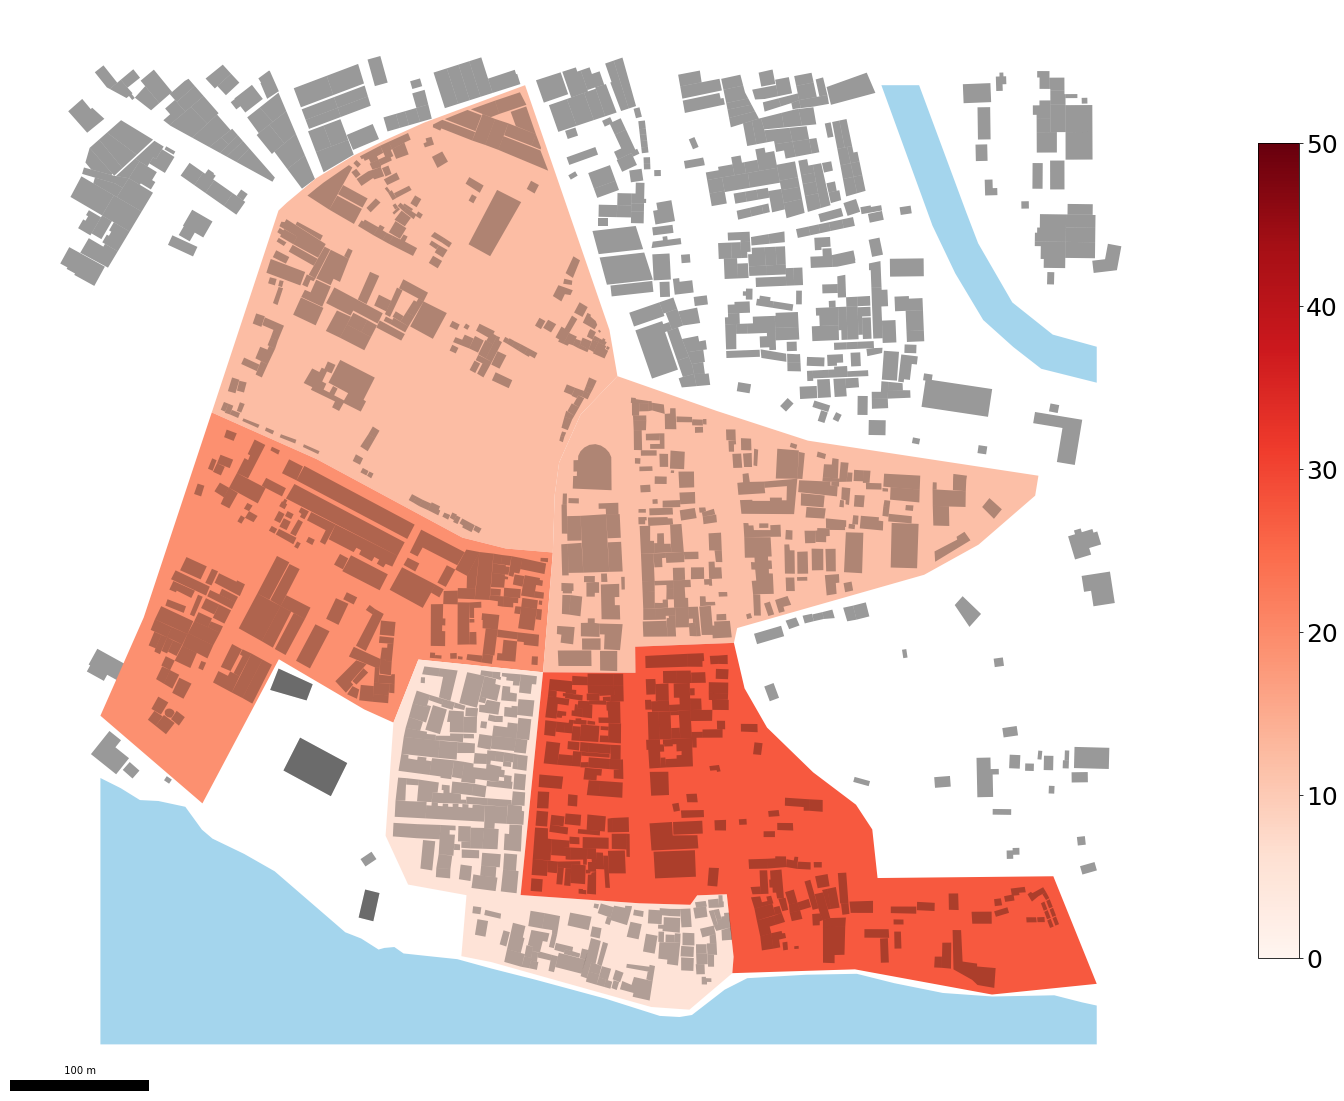

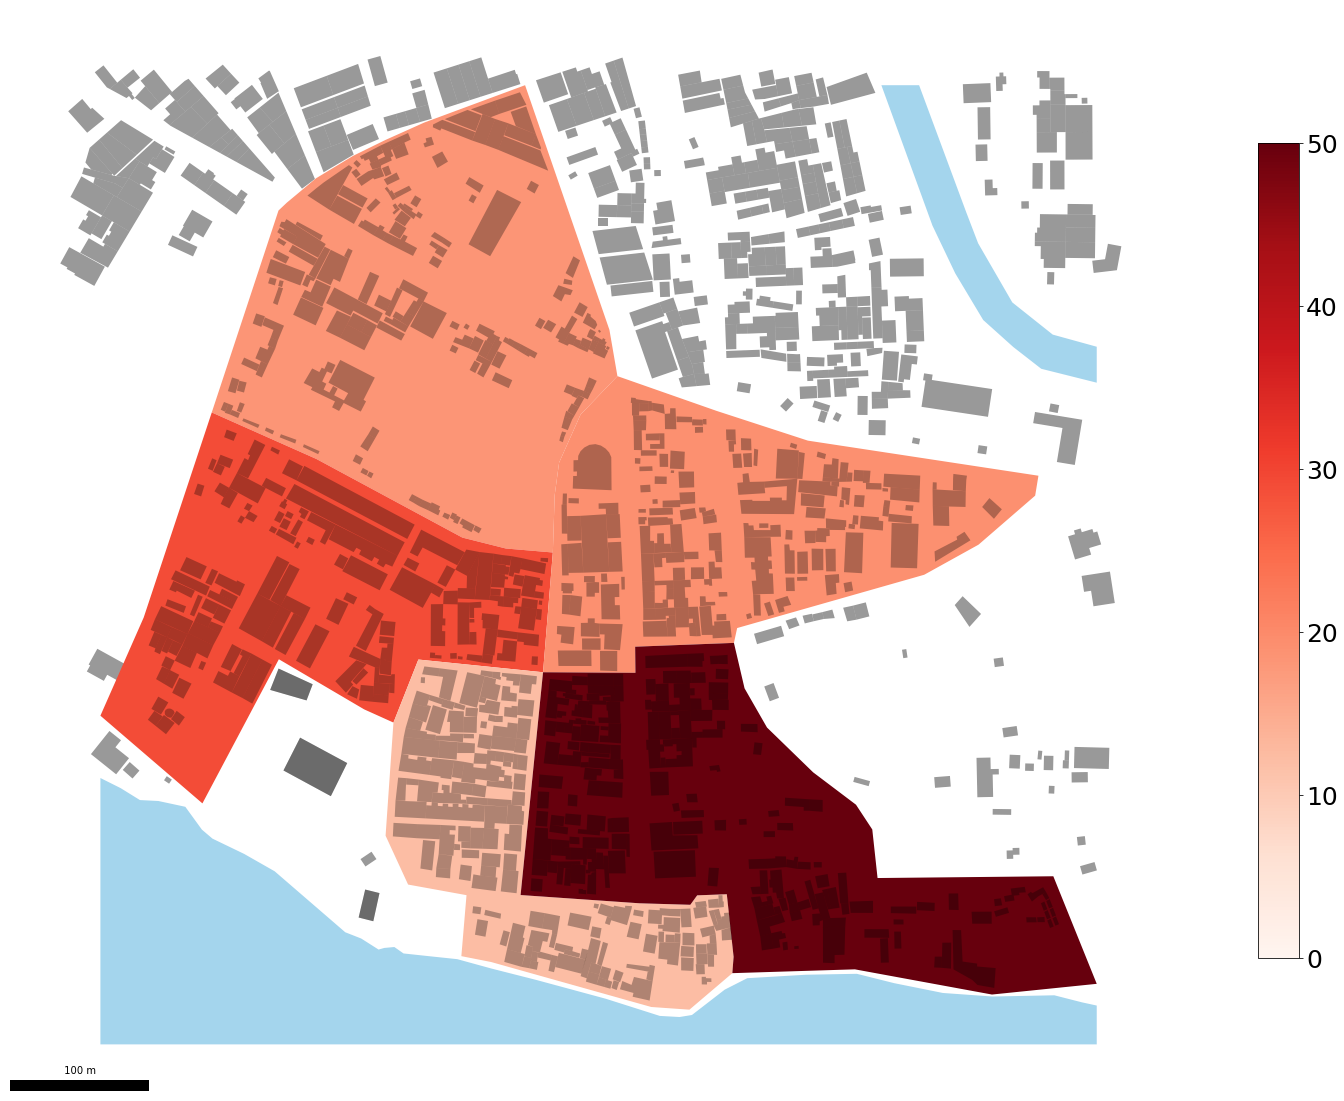

In [12]:
## Prevalence of diarrhoea - Azito

# get plot extent from gdf
xmin, ymin, xmax, ymax = sar_AZ.total_bounds

# Contextual elements (built environment and water surfaces)
ctxt_subset_azi = bdg_azi_ctxt.cx[xmin:xmax, ymin:ymax]# select buildings that fall within the extent of gdf
polygon = Polygon([(xmin, ymin-25), (xmin, ymax), (xmax, ymax), (xmax, ymin-25), (xmin, ymin-25)])
ctxt_subset_azi2 = wat_azi_ctxt.intersection(polygon)# clip water surfaces that fall within the extent of gdf

# General population
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_azi.plot(ax=ax,
                     color='black',
                     alpha=.4)
ctxt_subset_azi2.plot(ax=ax,
                      color='#68b9e2',
                      alpha=.6)
sar_AZ.plot(ax=ax,
            column='prev_gen', cmap='Reds',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
bdg_azi.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
#perimetre_azi.plot(ax=ax, edgecolor='blue', facecolor="none", linewidth=2.5)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Azito_1_diarrhea_genpop.png"),
            dpi=350,
            bbox_inches='tight'
           )

# Children under 5 years
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_azi.plot(ax=ax,
                     color='black',
                     alpha=.4)
ctxt_subset_azi2.plot(ax=ax,
                      color='#68b9e2',
                      alpha=.6)
sar_AZ.plot(ax=ax,
            column='prev_u5', cmap='Reds',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
bdg_azi.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
#perimetre_azi.plot(ax=ax, edgecolor='blue', facecolor="none", linewidth=2.5)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Azito_2_diarrhea_under5.png"),
            dpi=350,
            bbox_inches='tight'
           )

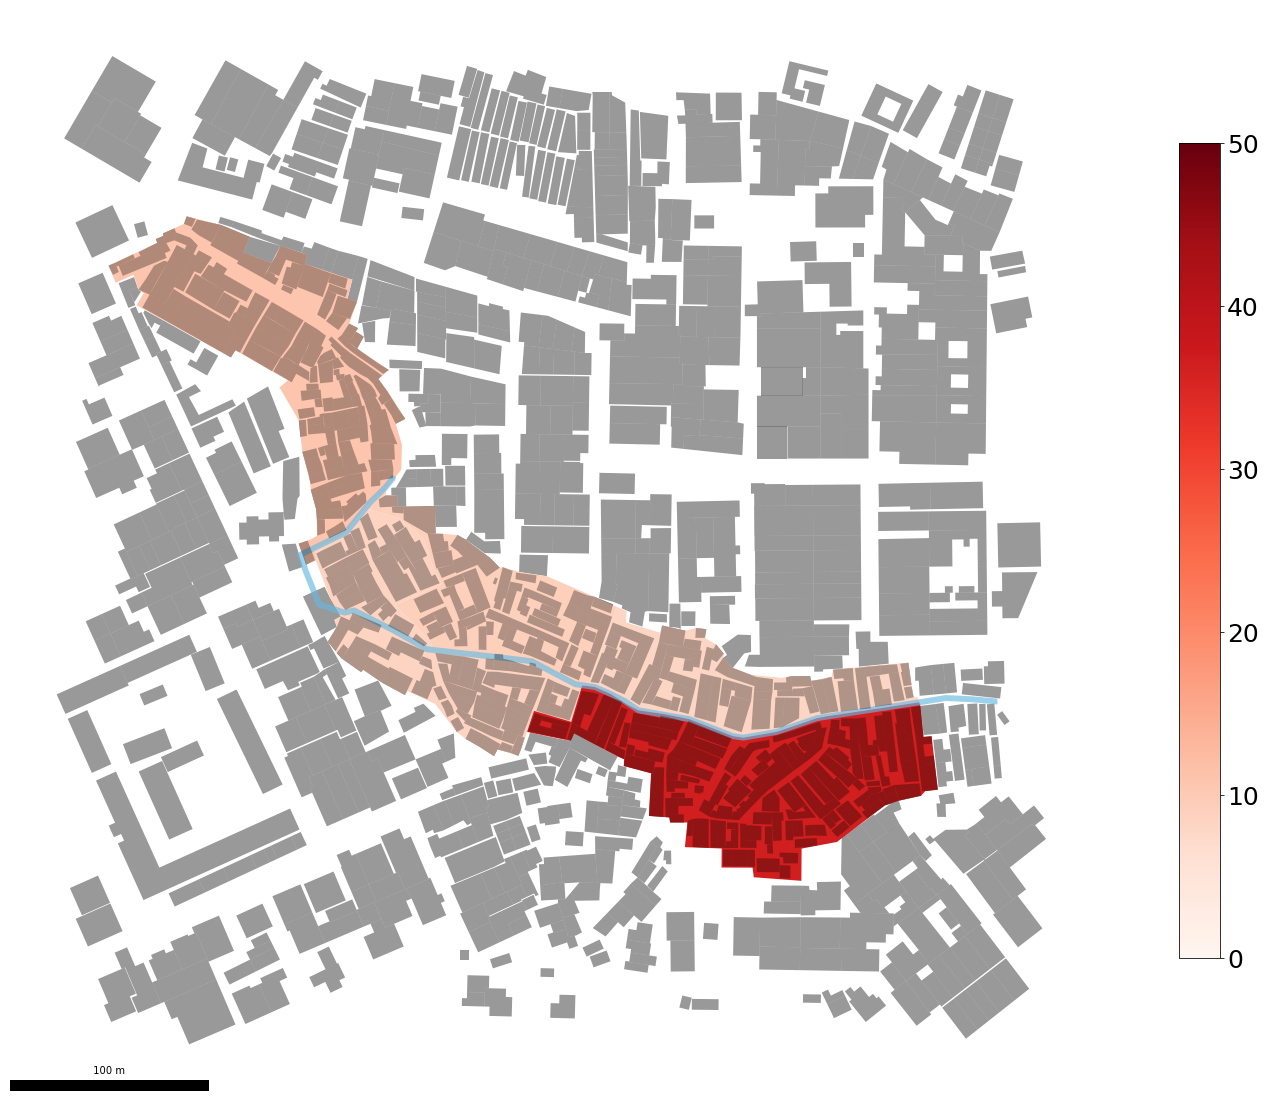

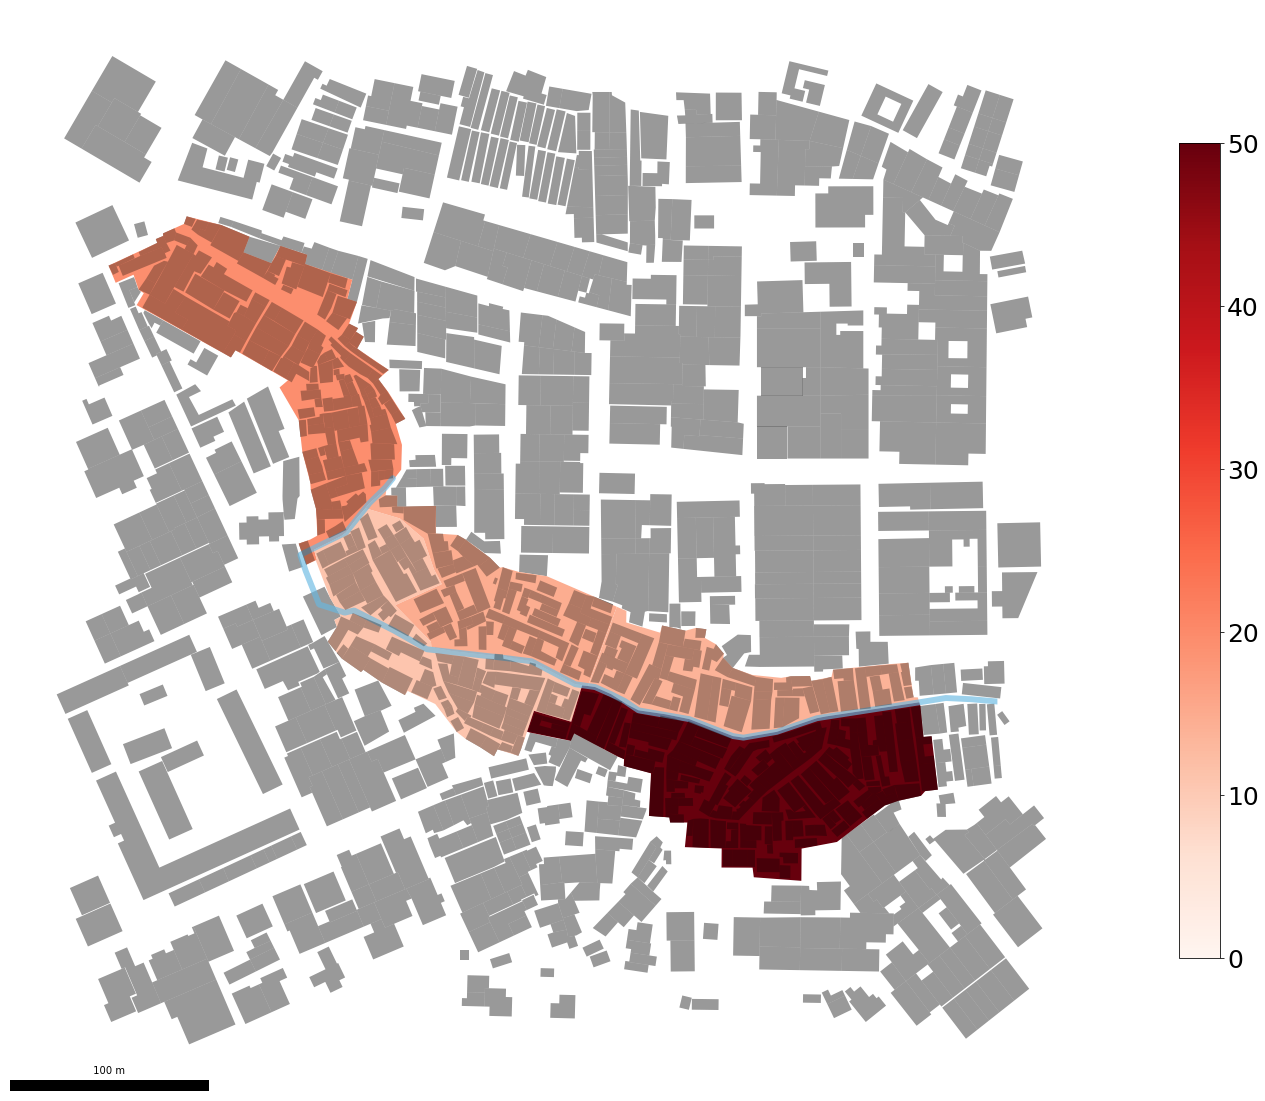

In [13]:
## Prevalence of diarrhoea - Williamsville

# get plot extent from gdf
xmin, ymin, xmax, ymax = sar_WI.total_bounds

# Contextual elements (built environment and water surfaces)
x_buffer = 30
y_buffer = 60
ctxt_subset_willy = bdg_willy_ctxt.cx[xmin:xmax+x_buffer, ymin-y_buffer:ymax+y_buffer]# select buildings that fall within the extent of gdf
polygon = Polygon([(xmin, ymin-y_buffer), (xmin, ymax+y_buffer), (xmax+x_buffer, ymax+y_buffer), (xmax+x_buffer, ymin-y_buffer), (xmin, ymin-y_buffer)])
ctxt_subset_willy2 = wat_willy_ctxt.intersection(polygon)# clip water surfaces that fall within the extent of gdf

# General population
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_willy.plot(ax=ax,
                       color='black',
                       alpha=.4)
sar_WI.plot(ax=ax,
            column='prev_gen', cmap='Reds',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
ctxt_subset_willy2.plot(ax=ax,
                        color='#68b9e2',
                        alpha=.65)
bdg_willy.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Willy_1_diarrhea_genpop.png"),
            dpi=350,
            bbox_inches='tight'
           )

# Children under 5 years
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_willy.plot(ax=ax,
                       color='black',
                       alpha=.4)
sar_WI.plot(ax=ax,
            column='prev_u5', cmap='Reds',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
ctxt_subset_willy2.plot(ax=ax,
                        color='#68b9e2',
                        alpha=.65)
bdg_willy.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Willy_2_diarrhea_under5.png"),
            dpi=350,
            bbox_inches='tight'
           )

## 3.2. Access to 'basic' hygiene amenities

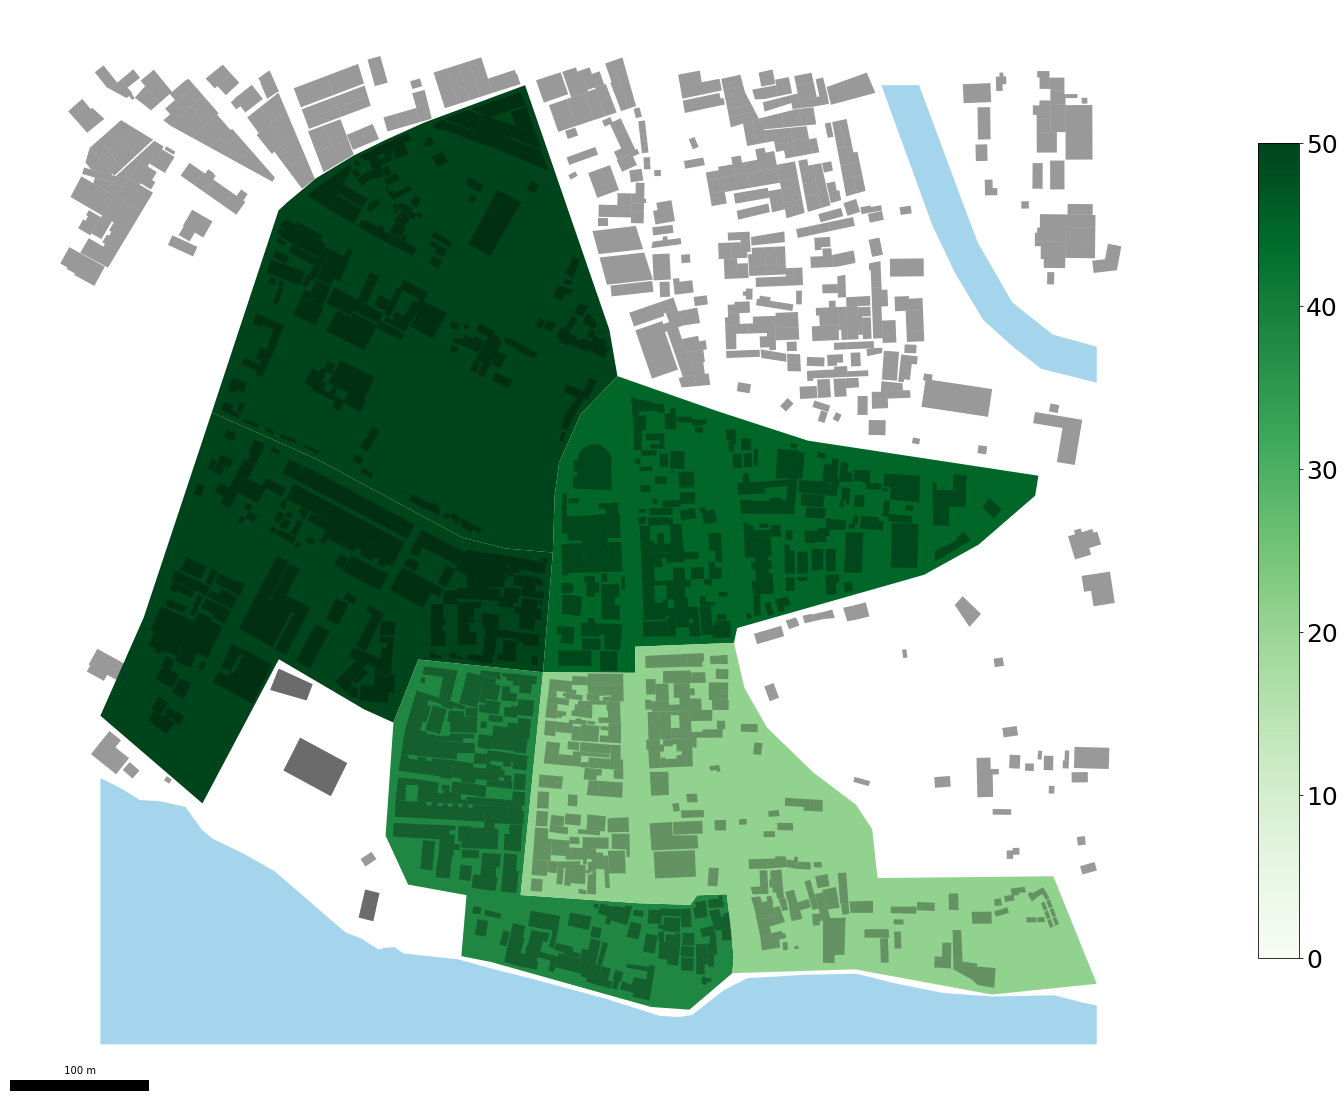

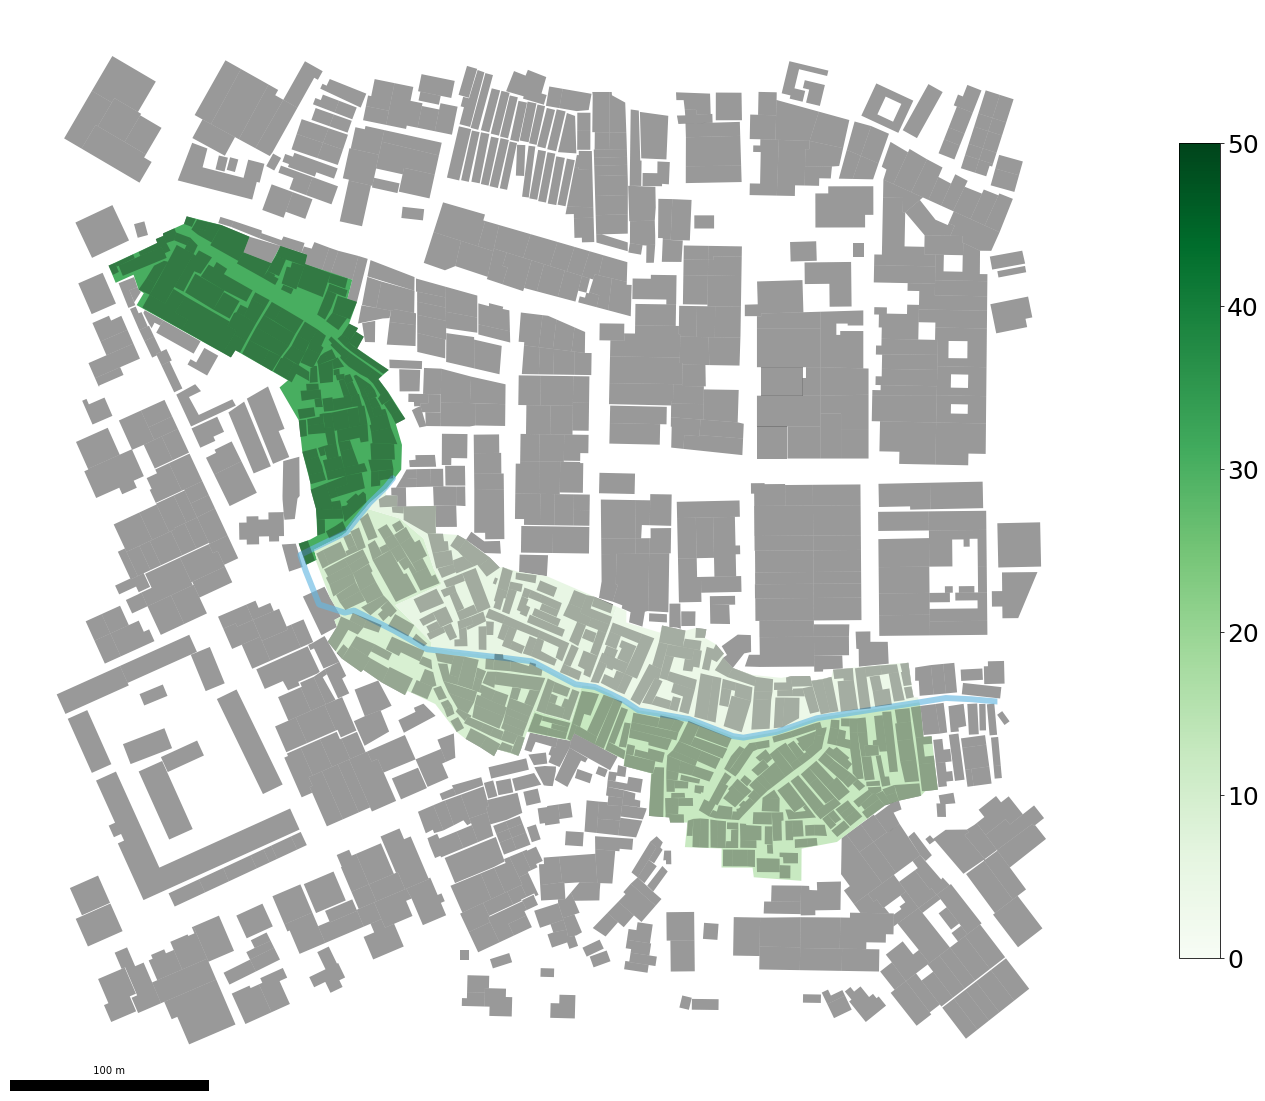

In [14]:
## Percentage of dwellings with soap, water and a fixed hand-washing structure available
#  (observed at the moment of the survey)

# Azito
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_azi.plot(ax=ax,
                     color='black',
                     alpha=.4)
ctxt_subset_azi2.plot(ax=ax,
                      color='#68b9e2',
                      alpha=.6)
sar_AZ.plot(ax=ax,
            column='pc_bhyg', cmap='Greens',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
bdg_azi.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Azito_3_basic_hyg.png"),
            dpi=350,
            bbox_inches='tight'
           )

# Williamsville
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_willy.plot(ax=ax,
                       color='black',
                       alpha=.4)
sar_WI.plot(ax=ax,
            column='pc_bhyg', cmap='Greens',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
ctxt_subset_willy2.plot(ax=ax,
                        color='#68b9e2',
                        alpha=.65)
bdg_willy.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Willy_3_basic_hyg.png"),
            dpi=350,
            bbox_inches='tight'
           )

## 3.3. Precarious construction materials

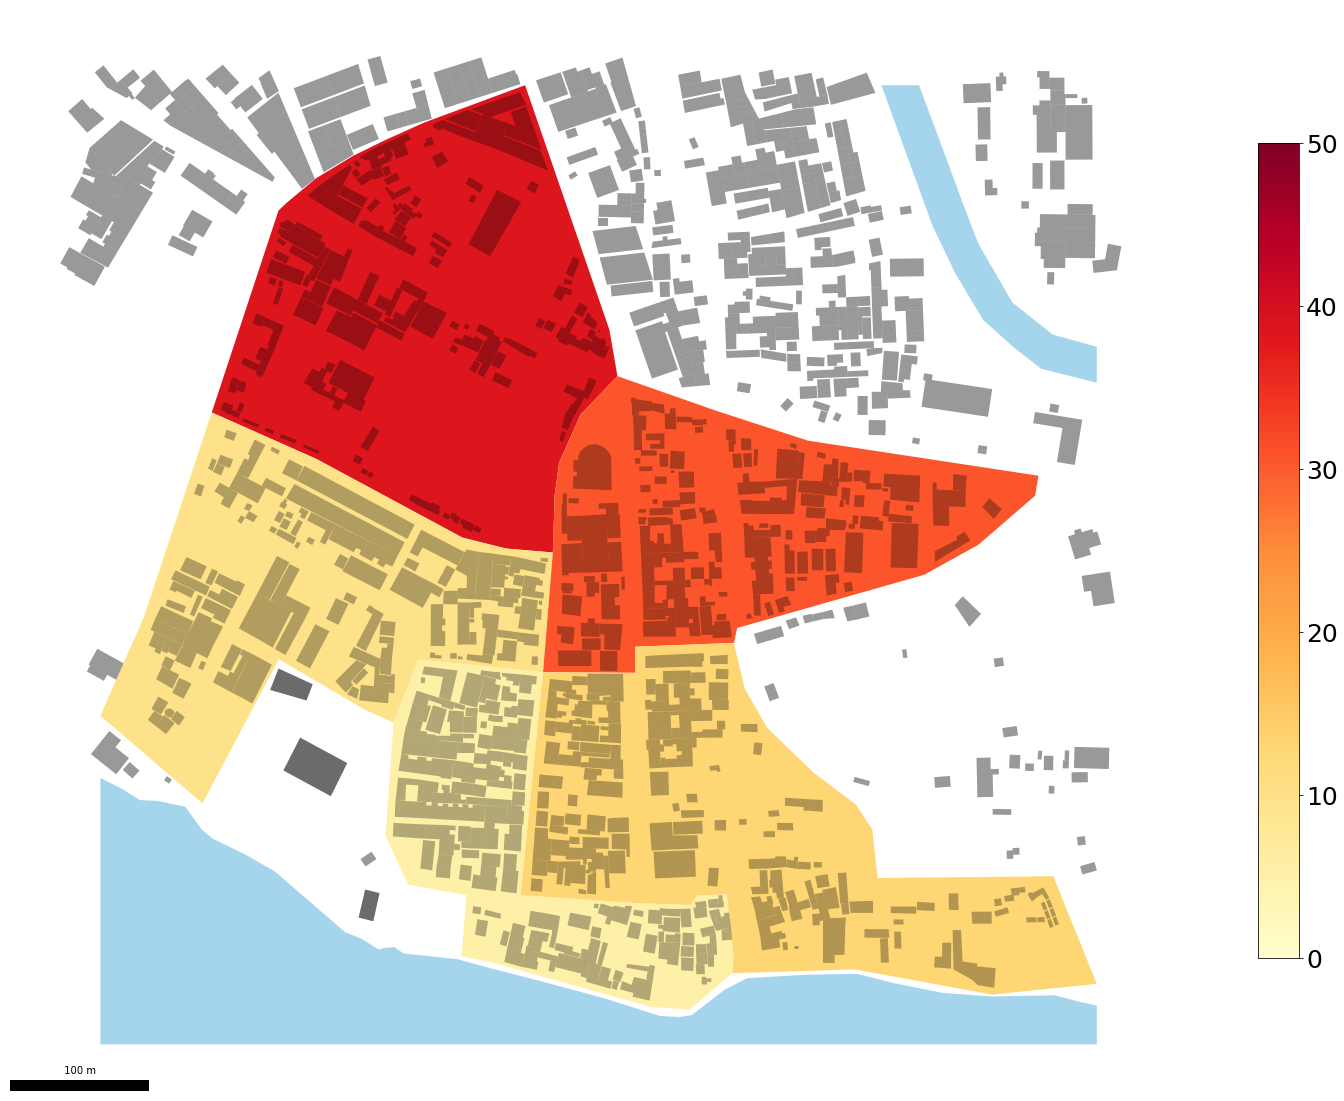

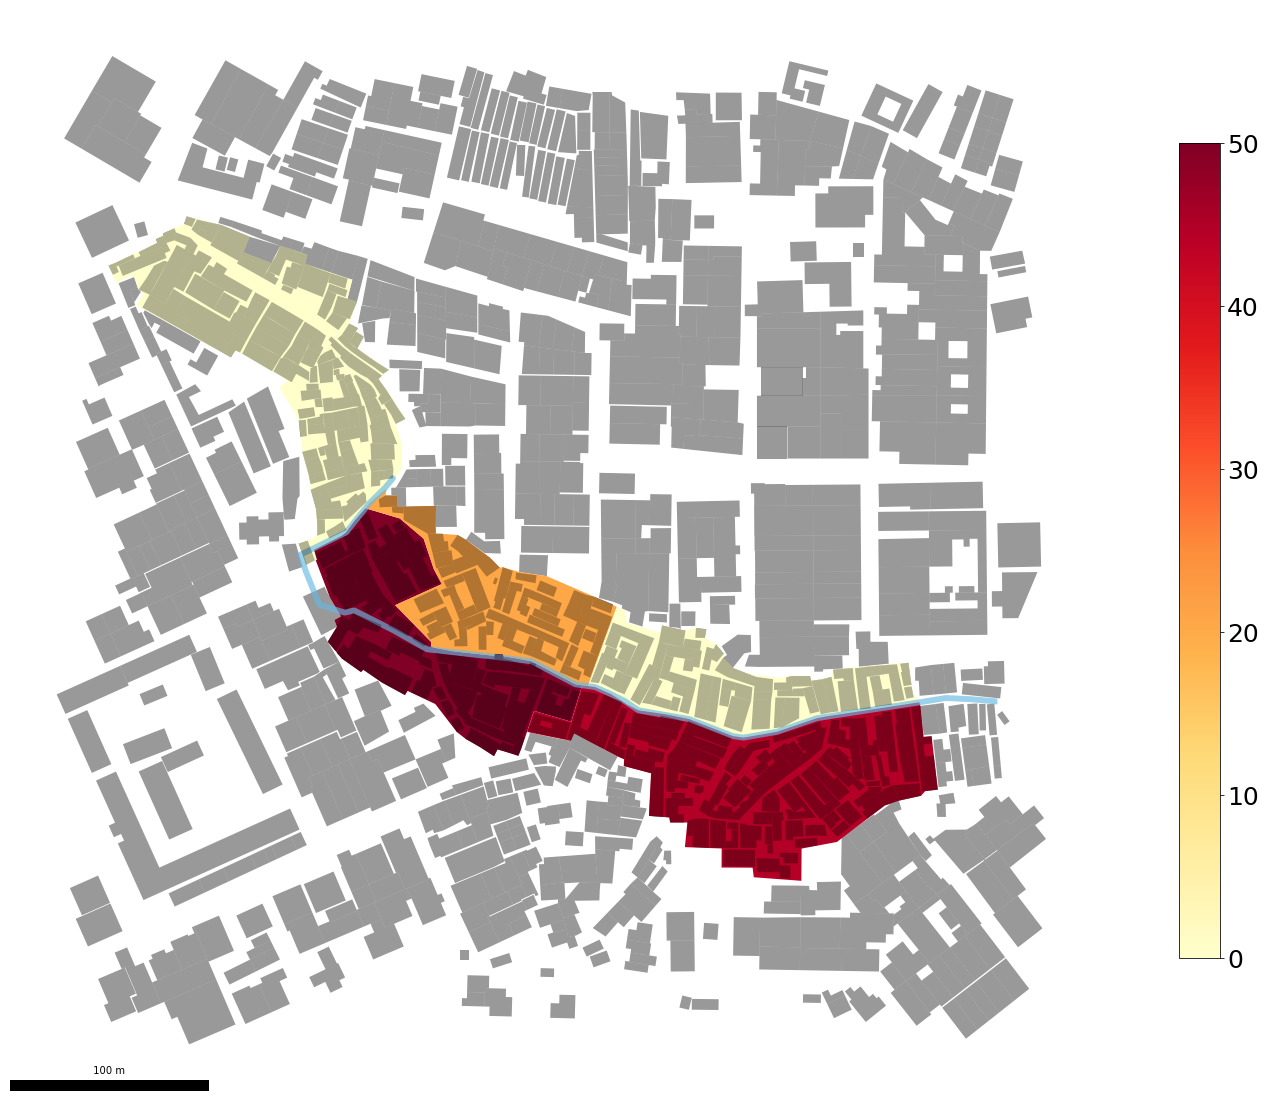

In [15]:
## Percentage of dwellings built with precarious construction materials

# Azito
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_azi.plot(ax=ax,
                     color='black',
                     alpha=.4)
ctxt_subset_azi2.plot(ax=ax,
                      color='#68b9e2',
                      alpha=.6)
sar_AZ.plot(ax=ax,
            column='pc_precmat', cmap='YlOrRd',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
bdg_azi.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Azito_4_prec_mat.png"),
            dpi=350,
            bbox_inches='tight'
           )

# Williamsville
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_willy.plot(ax=ax,
                       color='black',
                       alpha=.4)
sar_WI.plot(ax=ax,
            column='pc_precmat', cmap='YlOrRd',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
ctxt_subset_willy2.plot(ax=ax,
                        color='#68b9e2',
                        alpha=.65)
bdg_willy.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Willy_4_prec_mat.png"),
            dpi=350,
            bbox_inches='tight'
           )

## 3.4. Cooking space

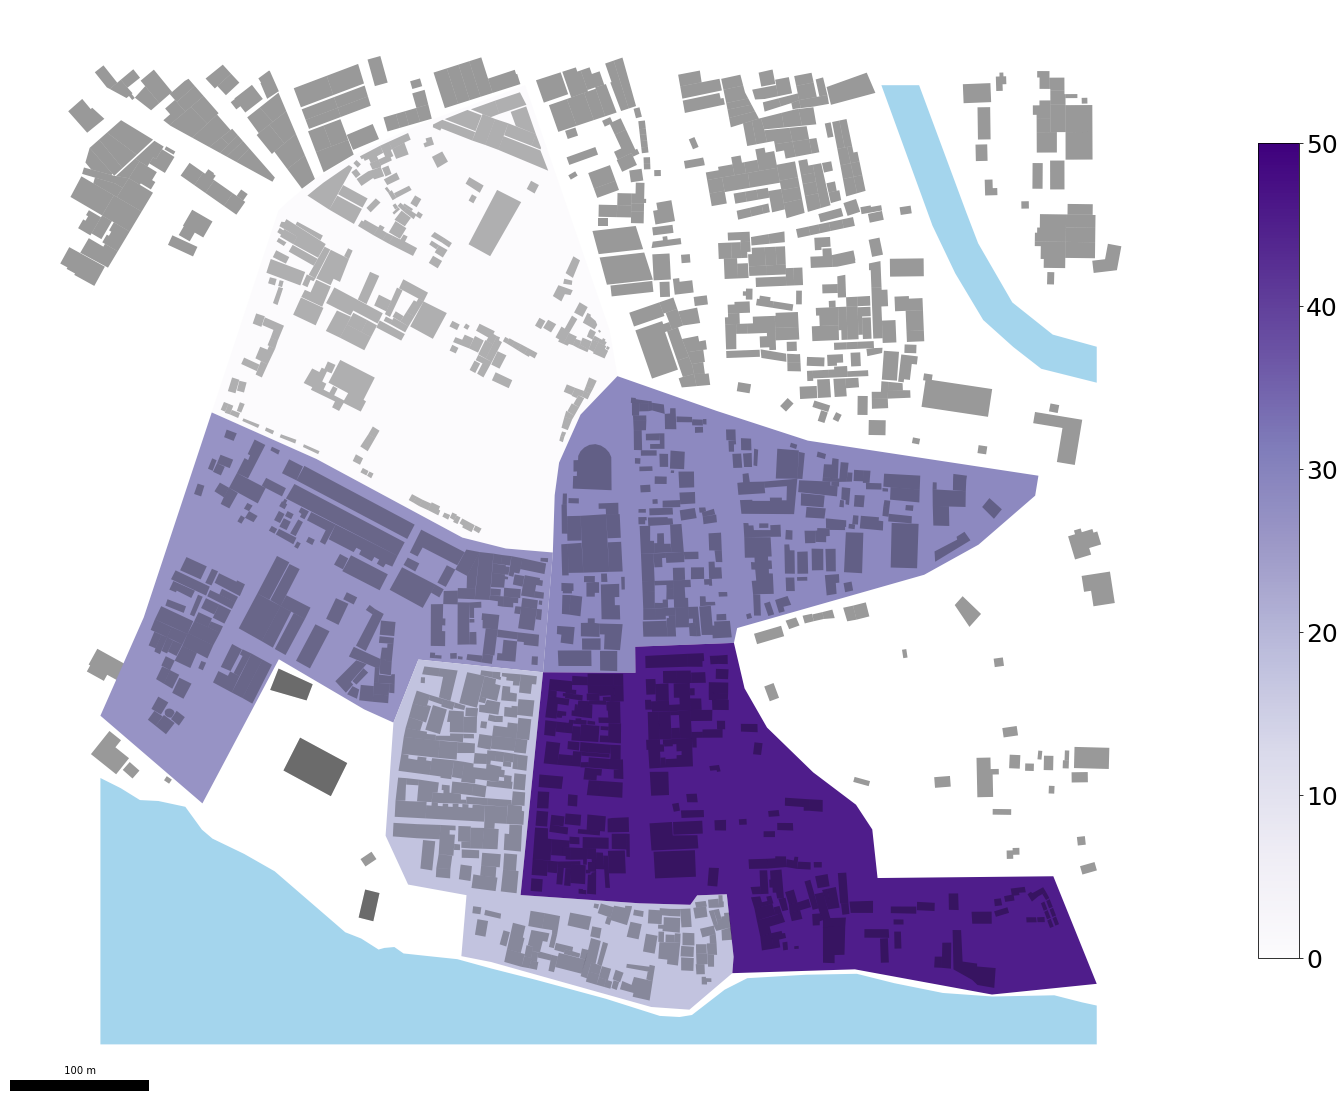

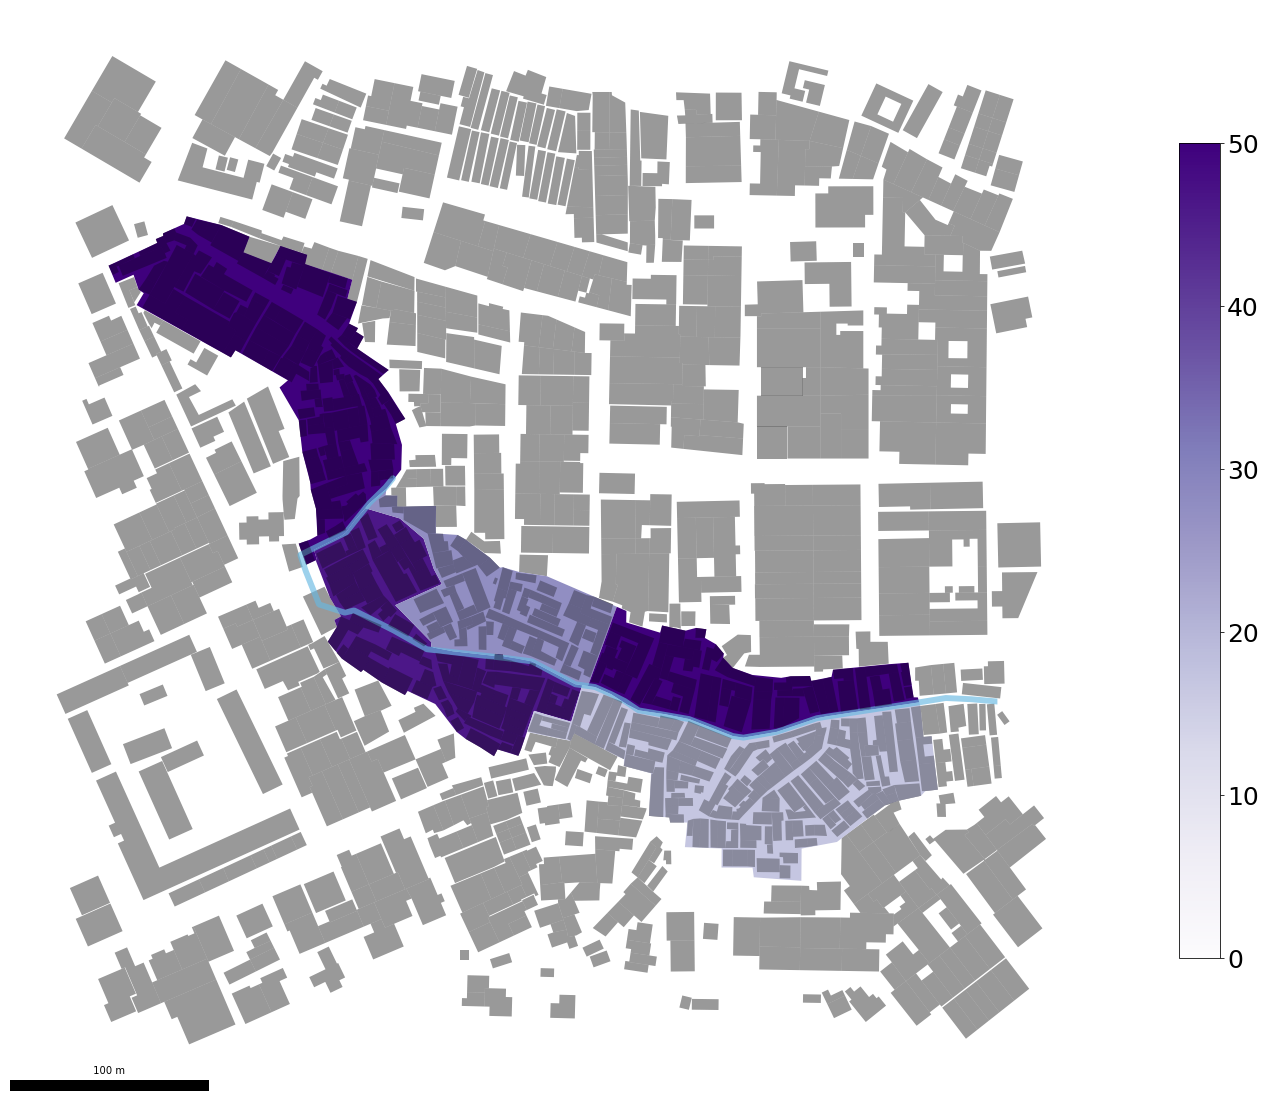

In [16]:
## Percentage of dwellings without an OUTDOORS cooking space

# Azito
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_azi.plot(ax=ax,
                     color='black',
                     alpha=.4)
ctxt_subset_azi2.plot(ax=ax,
                      color='#68b9e2',
                      alpha=.6)
sar_AZ.plot(ax=ax,
            column='pc_cookout', cmap='Purples',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
bdg_azi.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Azito_5_out_cooking.png"),
            dpi=350,
            bbox_inches='tight'
           )


## Percentage of dwellings without an INDOORS cooking space

# Williamsville
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_willy.plot(ax=ax,
                       color='black',
                       alpha=.4)
sar_WI.plot(ax=ax,
            column='pc_cookind', cmap='Purples',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
ctxt_subset_willy2.plot(ax=ax,
                        color='#68b9e2',
                        alpha=.65)
bdg_willy.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Willy_5_ins_cooking.png"),
            dpi=350,
            bbox_inches='tight'
           )

## 3.5. Availability of water

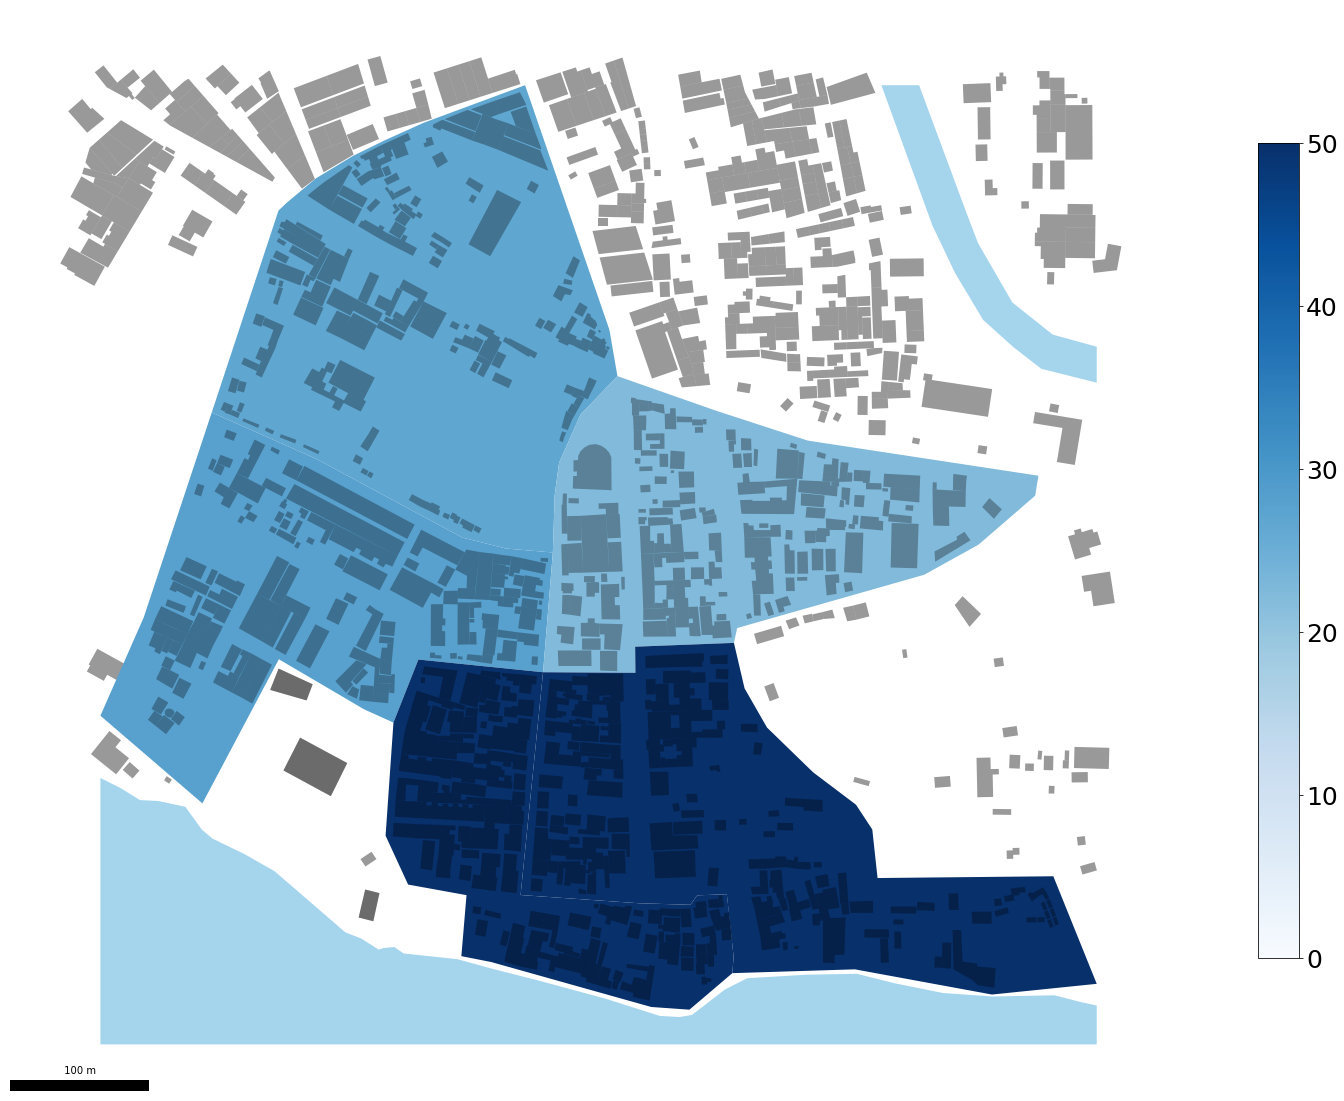

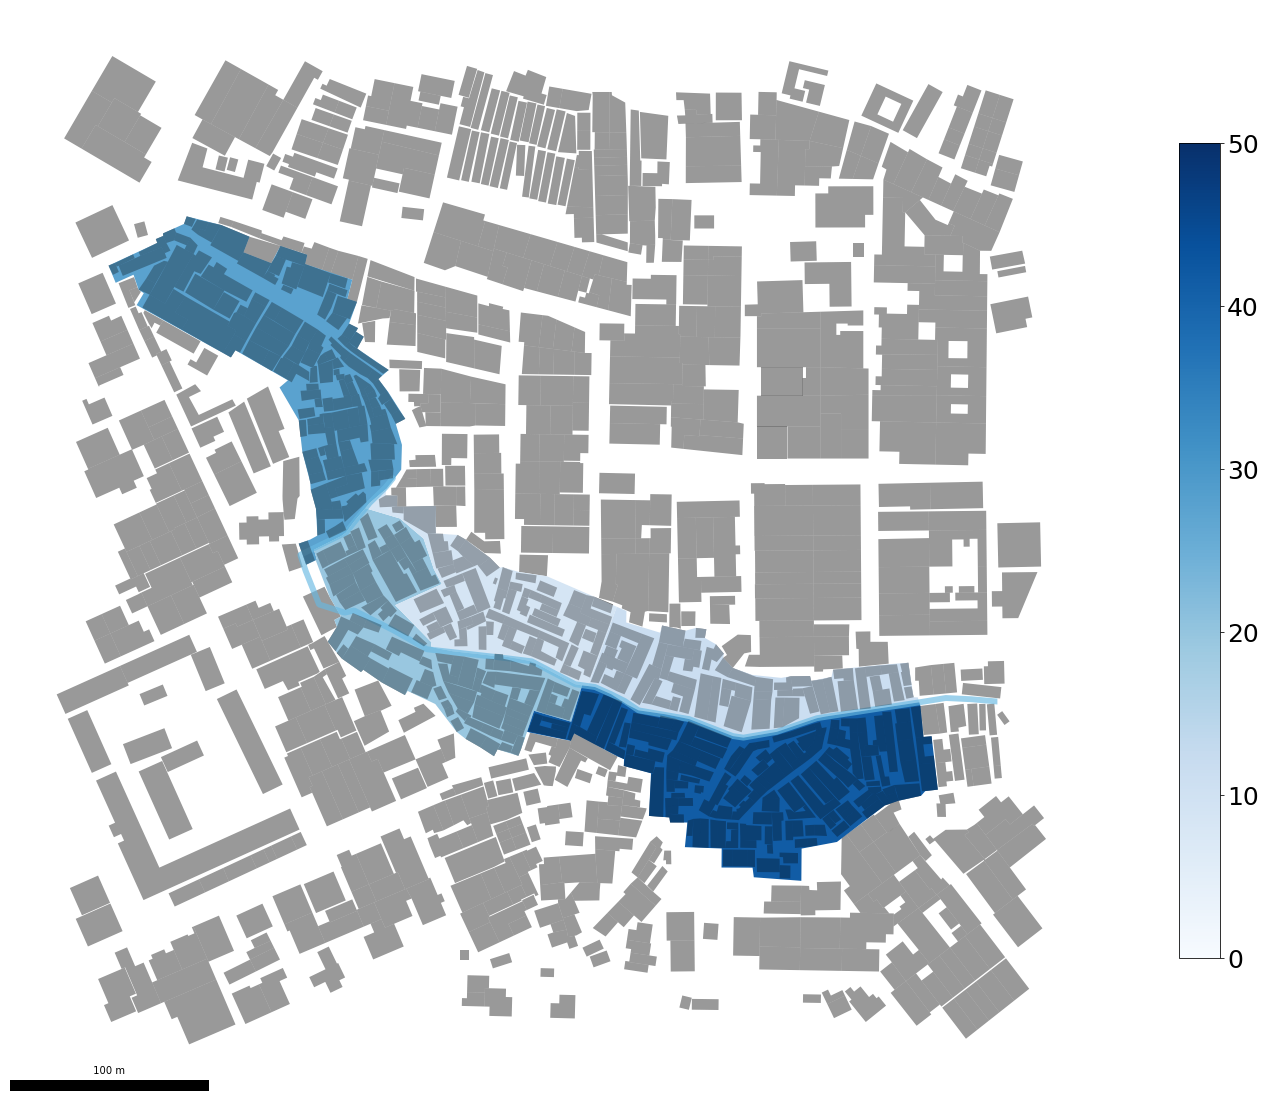

In [17]:
## Percentage of households that lacked water 
#  in the month preceding the survey (self reported)

# Azito
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_azi.plot(ax=ax,
                     color='black',
                     alpha=.4)
ctxt_subset_azi2.plot(ax=ax,
                      color='#68b9e2',
                      alpha=.6)
sar_AZ.plot(ax=ax,
            column='pc_wt_avm', cmap='Blues',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
bdg_azi.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Azito_6_avb_water.png"),
            dpi=350,
            bbox_inches='tight'
           )

# Williamsville
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_willy.plot(ax=ax,
                       color='black',
                       alpha=.4)
sar_WI.plot(ax=ax,
            column='pc_wt_avm', cmap='Blues',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
ctxt_subset_willy2.plot(ax=ax,
                        color='#68b9e2',
                        alpha=.65)
bdg_willy.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Willy_6_avb_water.png"),
            dpi=350,
            bbox_inches='tight'
           )

## 3.6. Access to basic WASH

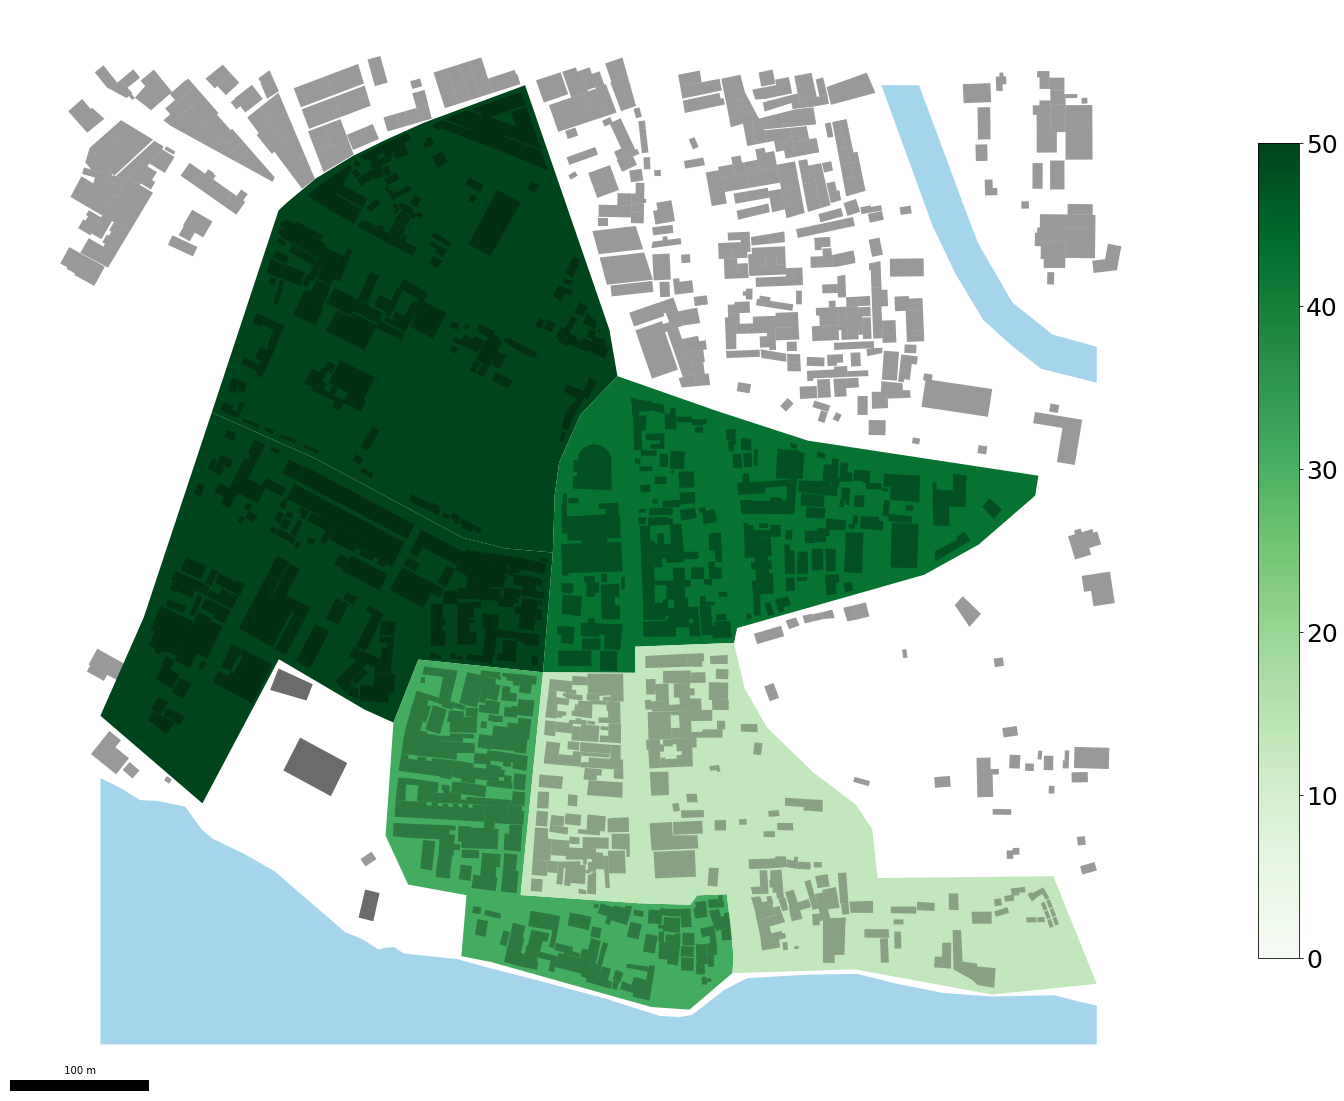

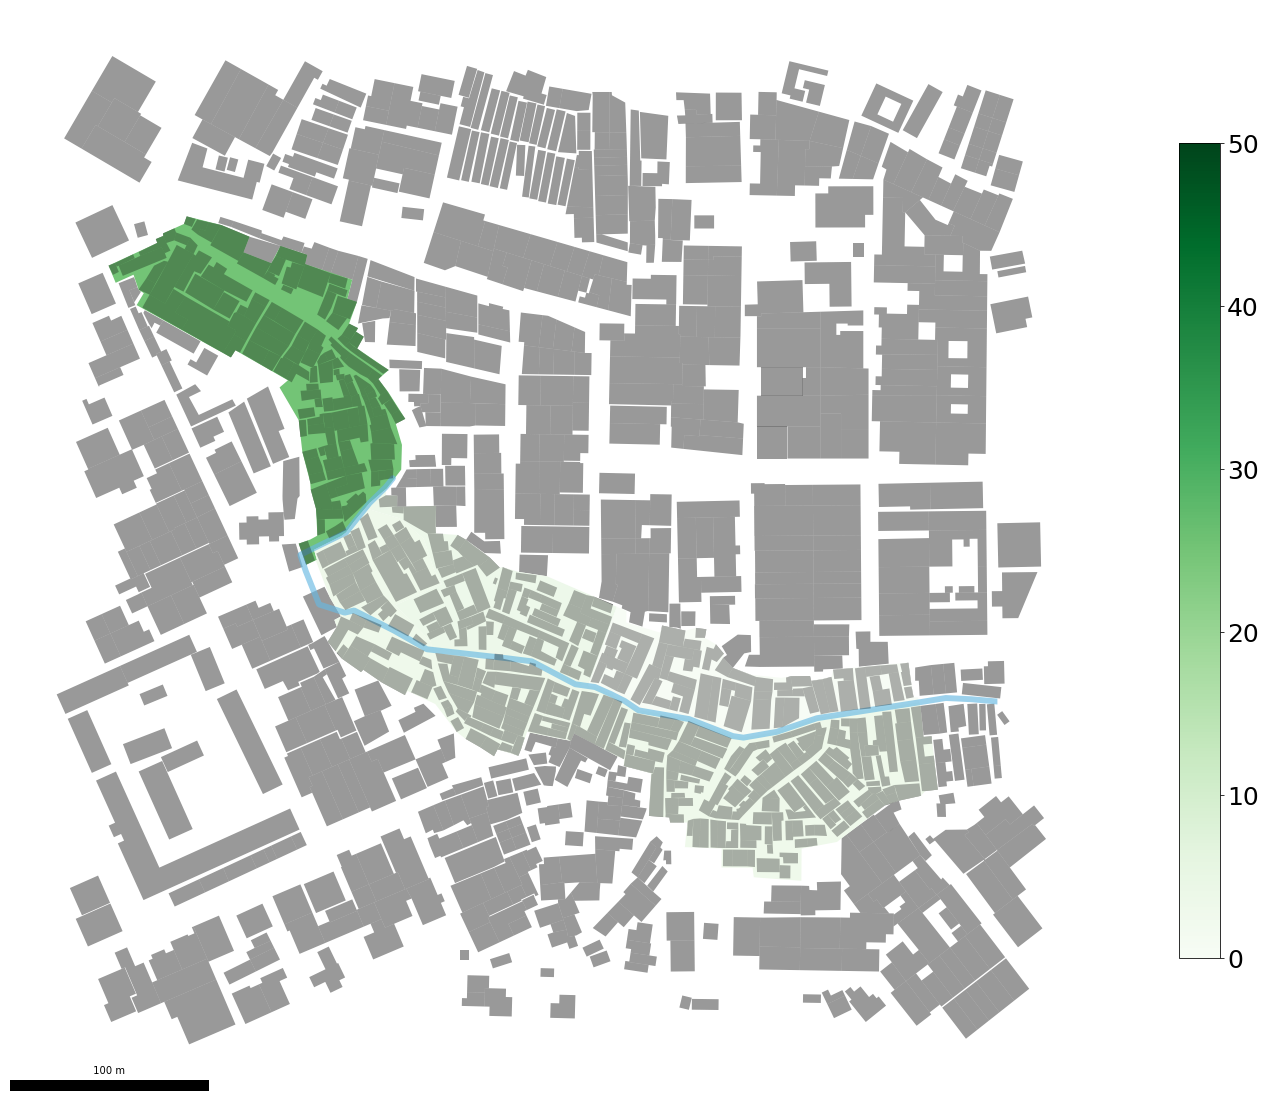

In [20]:
## Percentage of dwellings with accesss to all 3 basic WASH services

# Azito
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_azi.plot(ax=ax,
                     color='black',
                     alpha=.4)
ctxt_subset_azi2.plot(ax=ax,
                      color='#68b9e2',
                      alpha=.6)
sar_AZ.plot(ax=ax,
            column='pc_wash', cmap='Greens',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
bdg_azi.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Azito_7_basic_wash.png"),
            dpi=350,
            bbox_inches='tight'
           )

# Williamsville
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_willy.plot(ax=ax,
                       color='black',
                       alpha=.4)
sar_WI.plot(ax=ax,
            column='pc_wash', cmap='Greens',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
ctxt_subset_willy2.plot(ax=ax,
                        color='#68b9e2',
                        alpha=.65)
bdg_willy.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Willy_7_basic_wash.png"),
            dpi=350,
            bbox_inches='tight'
           )

## 3.7. Socioeconomic status

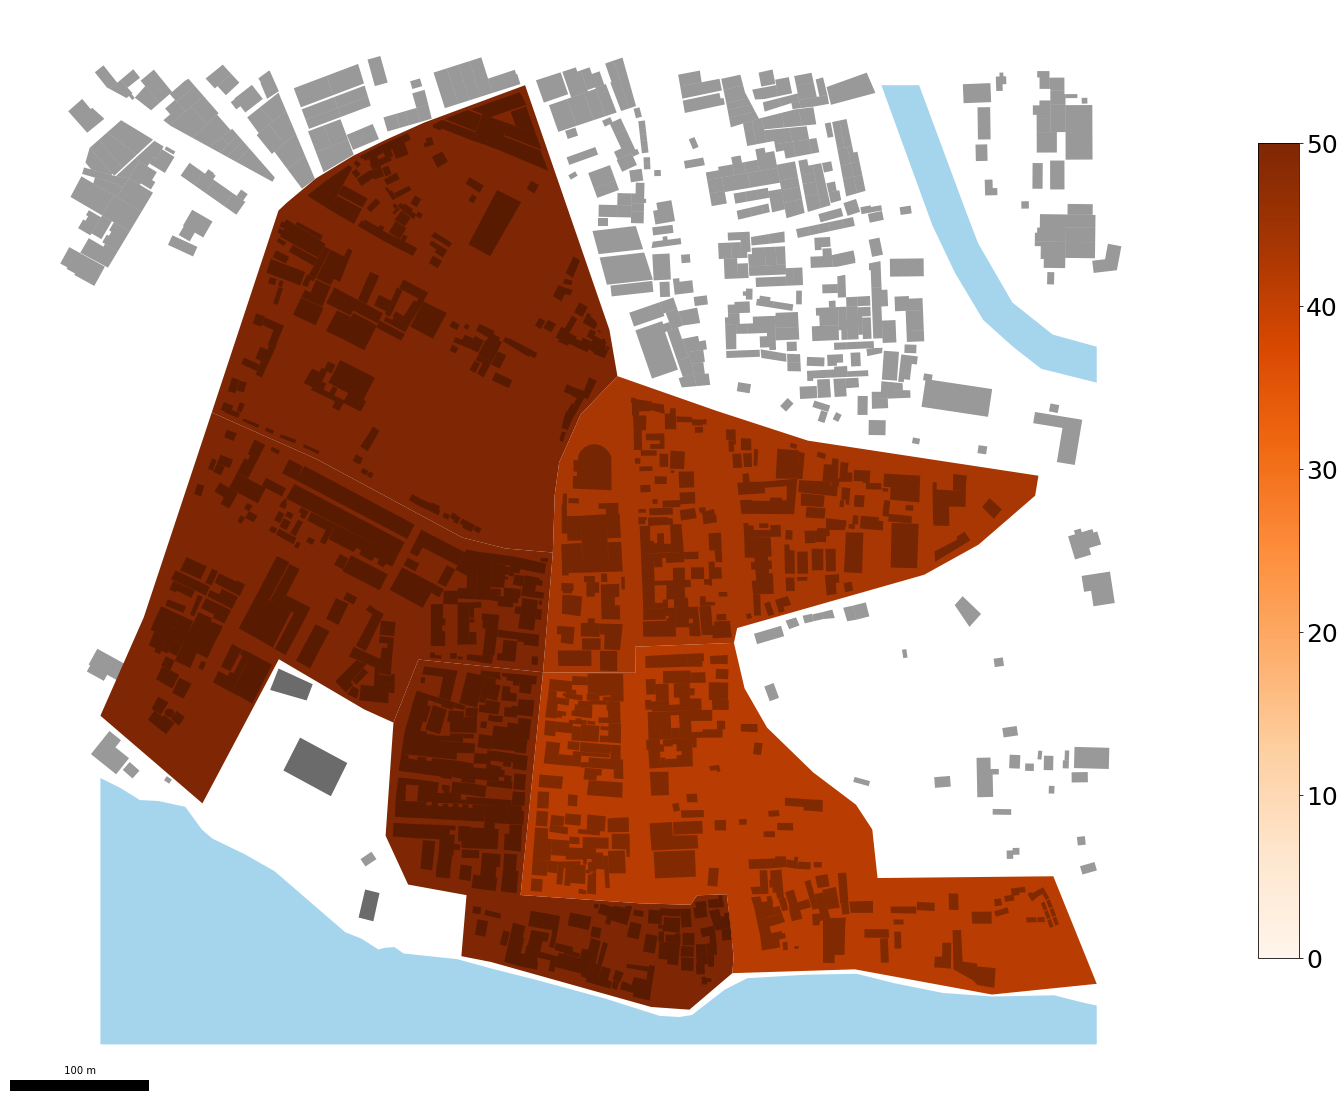

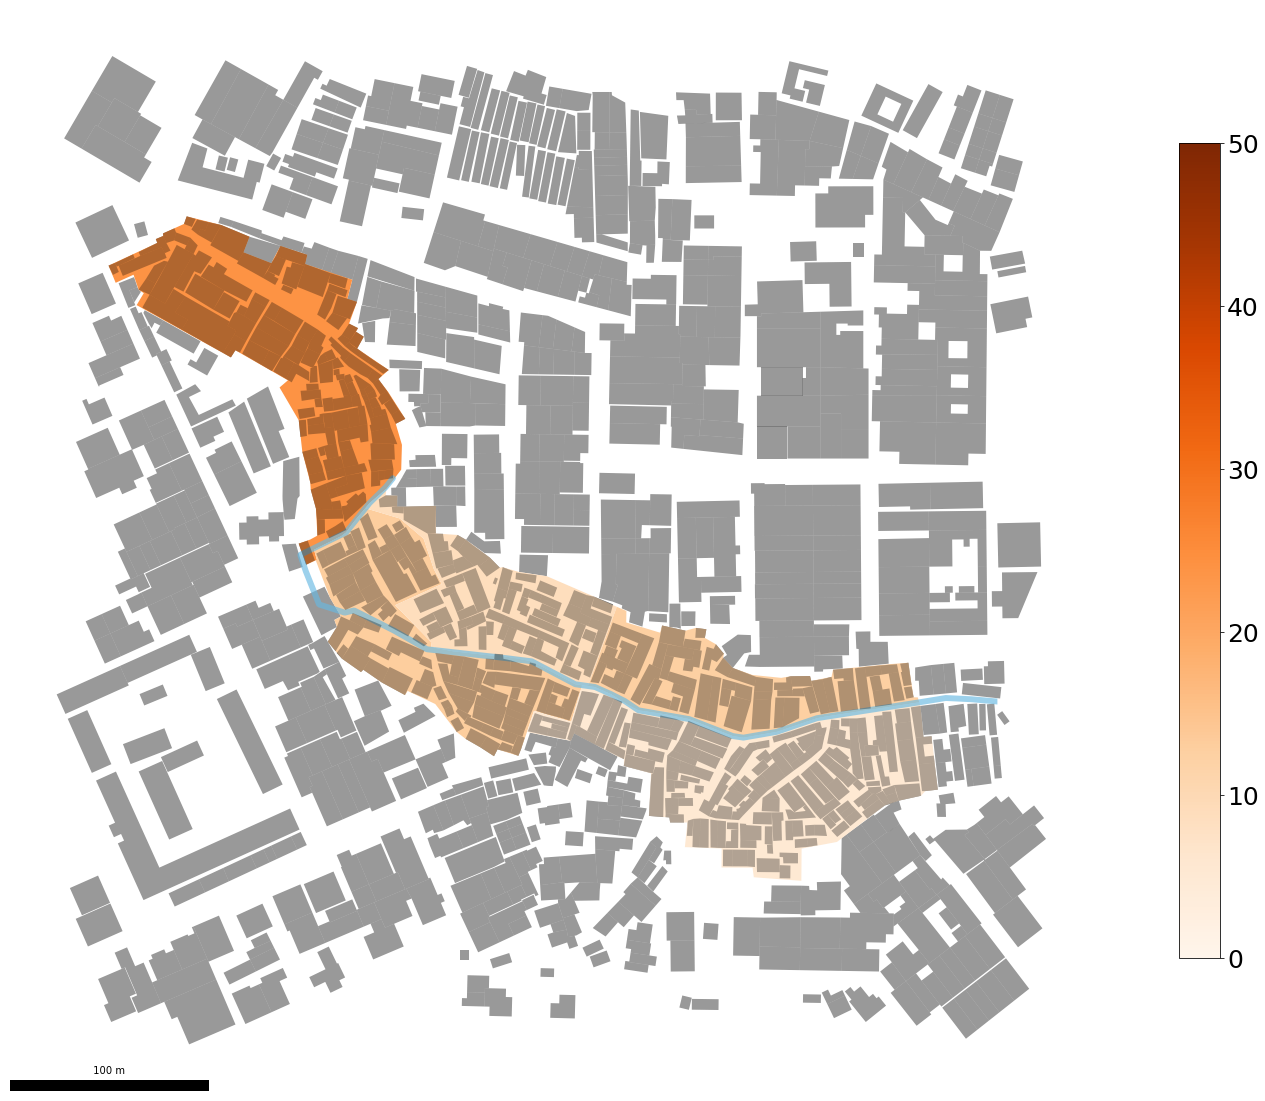

In [19]:
## Percentage of households in the 'high' socioeconomic stratum:
#  with more assets than the series' average,
#  AND with a head of household having attained secondary education

# Azito
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_azi.plot(ax=ax,
                     color='black',
                     alpha=.4)
ctxt_subset_azi2.plot(ax=ax,
                      color='#68b9e2',
                      alpha=.6)
sar_AZ.plot(ax=ax,
            column='pc_hi_soceco', cmap='Oranges',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
bdg_azi.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Azito_8_socioeco.png"),
            dpi=350,
            bbox_inches='tight'
           )

# Williamsville
f, ax = plt.subplots(figsize=(30, 20))
ctxt_subset_willy.plot(ax=ax,
                       color='black',
                       alpha=.4)
sar_WI.plot(ax=ax,
            column='pc_hi_soceco', cmap='Oranges',
            vmin=0, vmax=50,
            legend=True, legend_kwds={'shrink': 0.75},
            alpha=1)
ctxt_subset_willy2.plot(ax=ax,
                        color='#68b9e2',
                        alpha=.65)
bdg_willy.plot(ax=ax,
             color='black',
             legend=True, legend_kwds={'shrink': 0.75},
             alpha=.3)
ax.set_axis_off()
ax.add_artist(ScaleBar(dx=1,
                       units="m",
                       dimension="si-length",
                       length_fraction=0.25,
                       scale_formatter=lambda value, unit: f' {value} m ',
                       location='lower left',
                       scale_loc='top',
                       fixed_value=100,
                       font_properties={'size':10}
                      ))
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=25)
plt.show()

# SAVE plot
fig = ax.get_figure()
fig.savefig(path.join(root_dir,
                      "data/output/maps/Willy_8_socioeco.png"),
            dpi=350,
            bbox_inches='tight'
           )